# ROC-AUC made simpler


In [13]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score

We will try to plot the ROC curve and calculate the AUC quickly in this book. You can use this code for your assigments as the code examples will be simpler.


In [2]:
csv_url = 'https://raw.githubusercontent.com/Statology/Python-Guides/main/default.csv'


default=pd.read_csv(csv_url)

In [3]:
default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [4]:
X=default[['student', 'balance', 'income']]
y=default['default']

Let's do a train test split

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=0)


In [6]:
rf_clf=RandomForestClassifier()
y_score = rf_clf.fit(X_train, y_train).predict_proba(X_test)


In [7]:
y_score


array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.73, 0.27],
       [1.  , 0.  ],
       [1.  , 0.  ]])

Let's say we only care about the probabilities of going into default. Ergo when the column default is 1. So let's just select that as our prediction probability.

In [8]:
y_proba=y_score[:,1]

In [9]:
#get the false positive rate, true positive rate, and threshold
fpr, tpr , threshold= roc_curve(y_test,  y_proba)

#get the auc score
auc=roc_auc_score(y_test, y_proba)


In [10]:
#Put the results into a dataframe

results=pd.DataFrame({'fpr':fpr,'tpr':tpr,
                      'threshold':threshold})

results

,fpr,tpr,threshold
0,0.000000,0.000000,1.99
1,0.000519,0.000000,0.99
2,0.000519,0.027027,0.96
3,0.000519,0.054054,0.95
4,0.000519,0.067568,0.93
...,...,...,...
61,0.117861,0.783784,0.04
62,0.133437,0.797297,0.03
63,0.158359,0.824324,0.02
64,0.207684,0.864865,0.01


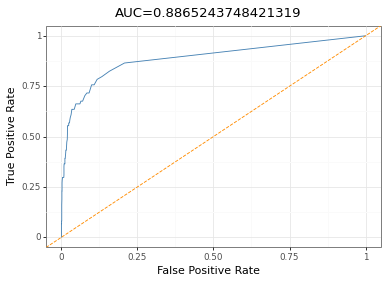

<ggplot: (8774668806410)>

In [11]:
#Plot

(ggplot(data=results, mapping=aes(x='fpr', y='tpr'))+
geom_line(color='steelblue')+
ggtitle(f'AUC={auc}')+
geom_abline(linetype='dashed', color='darkorange')+
 ylab("True Positive Rate")+
 xlab("False Positive Rate")+
 theme_bw()
)

We can try to combine this with K-fold cross validation to find the best model. Note that we can get the AUC like this:

In [14]:
cross_val_score(rf_clf, X, y, scoring="roc_auc", cv = 5)

array([0.87366034, 0.88012363, 0.86513887, 0.8870289 , 0.88266248])

This is reminiscent of what we have done in the past! Let's do this for AUC only on the test set!

In [21]:
scoresrf=[cross_val_score(RandomForestClassifier(n_estimators=100,
                                 max_depth=i),X,y,
                          scoring="roc_auc",
                          cv=5).mean() for i in list(range(1,15))
    ]

In [29]:
#Let's save this in a dataframe

rfdf=pd.DataFrame(scoresrf, columns=['AUC'])
rfdf['depth']=range(1,15)
rfdf.head()

,AUC,depth
0,0.784243,1
1,0.873300,2
2,0.914929,3
3,0.928999,4
4,0.933365,5


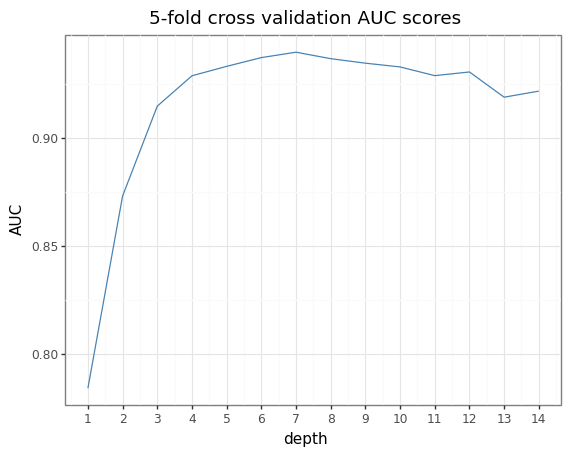

<ggplot: (8774660306571)>

In [33]:
#Let's plot this!

(ggplot(data=rfdf, mapping=aes(x='depth', y='AUC'))+
       geom_line(color='steelblue')+
 scale_x_continuous(breaks=np.arange(1,15, 1))+
 ggtitle('5-fold cross validation AUC scores')+
theme_bw())

In [35]:
#Let's find the optimal  depth
rfdf.loc[rfdf['AUC']==rfdf['AUC'].max(),:]

,AUC,depth
6,0.939916,7
